<bound method NDFrame.head of             Stock_Rate
Date                  
1987-02-01    8.390715
1987-03-01    1.200001
1987-04-01   -2.859804
1987-05-01   -0.311151
1987-06-01    1.968790
...                ...
2023-02-01   -1.113636
2023-03-01    6.689952
2023-04-01    0.038209
2023-05-01    5.796469
2023-06-01    5.074954

[437 rows x 1 columns]>
<bound method NDFrame.head of             Gold_Rate
Date                 
1987-02-01  -1.830737
1987-03-01   1.945667
1987-04-01   7.537520
1987-05-01   5.000398
1987-06-01  -2.679086
...               ...
2023-02-01   4.313938
2023-03-01  -5.194064
2023-04-01   7.717147
2023-05-01   0.609725
2023-06-01  -0.853492

[437 rows x 1 columns]>
<bound method NDFrame.head of             House_Rate
Date                  
1987-02-01    1.111119
1987-03-01    0.972811
1987-04-01    0.989851
1987-05-01    1.155351
1987-06-01    1.005952
...                ...
2022-12-01   -0.451810
2023-01-01   -0.144562
2023-02-01    0.051841
2023-03-01    0.588743

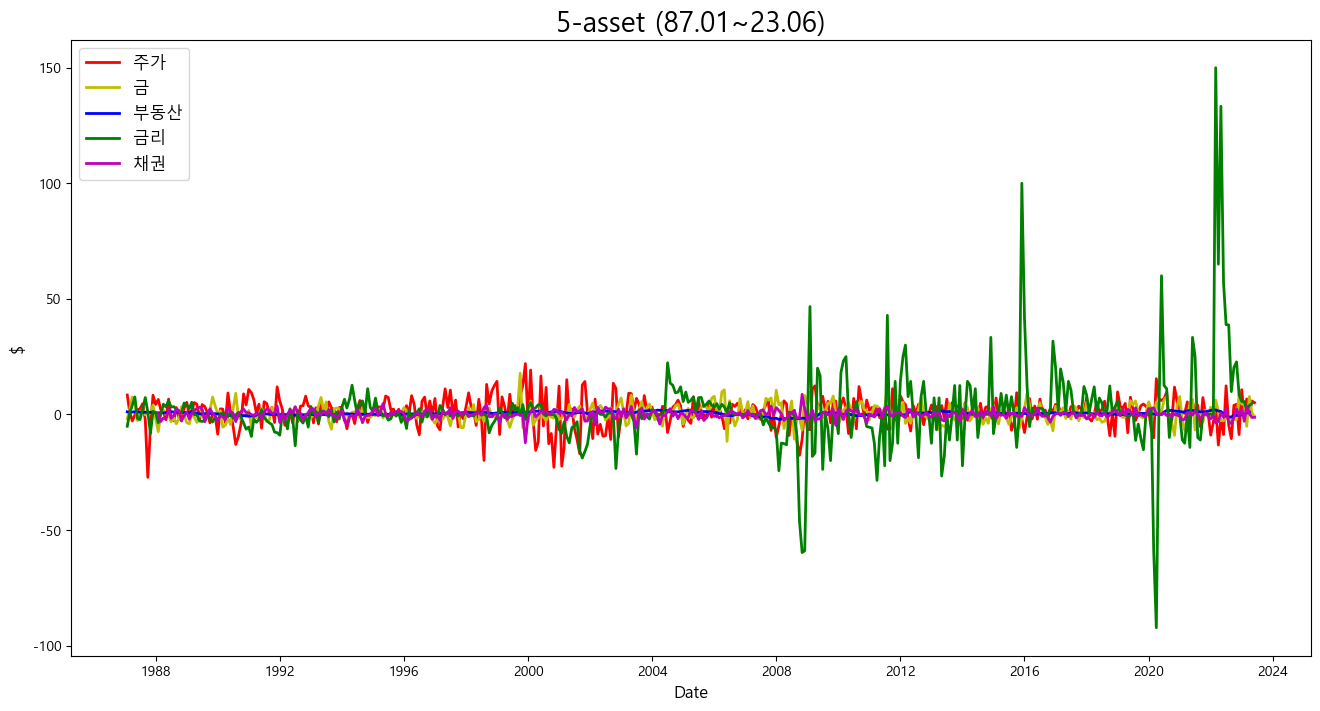

In [1]:
## 5가지 자산데이터(주식, 금, 부동산, 금리, 채권) 비율로 그래프 나오고 이들의 상관관계 나옴

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.stats.weightstats import ztest
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
from operator import itemgetter
from matplotlib.patches import Rectangle

from statsmodels.stats.weightstats import ztest
from statsmodels.tsa.seasonal import seasonal_decompose

import scipy.stats as stats

# CSV 파일 불러오기
stock_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/나스닥(1985~2023)_yfinance.csv')
gold_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/금(1950~2023)_캐글.csv')
interest_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/미국금리(1954.7~2023.5)_구글서치.csv')
house_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/케이스-쉴러_미국주택가격지수(1987.1~2023.4).csv')
bond_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/10년만기 미국채 선물 과거 데이터.csv')
gdp_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/1인당GDP.csv')

#######--------------------------------------- 데이터 전처리 -------------------------------------------#######

# 데이터프레임 컬럼 이름 바꾸기
gold_df = gold_df.rename(columns={'Price USD per Oz':'Gold_Price'})
interest_df = interest_df.rename(columns={'FEDFUNDS':'Funds_Rate', "DATE":"Date"})
house_df = house_df.rename(columns={'SPCS10RSA':'House_Price', "DATE":"Date"})
bond_df = bond_df.rename(columns={'종가':'Bond_Close', "날짜":"Date"})

# 불러올 날짜 구간 설정(공통 1987-01-01 ~ 2023-07-01)
start = "1987-01-01" # 최소 1950-01-01
end = "2023-06-01" # 최대 2023-07-01
stock_df = stock_df[stock_df['Date'].between(start, end)]
gold_df = gold_df[gold_df['Date'].between(start, end)]
interest_df = interest_df[interest_df['Date'].between(start, end)]
house_df = house_df[house_df['Date'].between(start, end)]
bond_df = bond_df[bond_df['Date'].between(start,end)]

# 특정 칼럼(열) 삭제
stock_df = stock_df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)
bond_df = bond_df.drop(['시가', '고가', '저가', '변동 %'], axis = 1)

### 모든 데이터를 변화율로 변환하고 필요없는 열 삭제
# 금리(지수->지수)
interest_df = interest_df.reset_index(drop=True)
interest_df['Interest_Rate'] = 0
interest_df['Funds_Rate'] = interest_df['Funds_Rate'] / interest_df.loc[0, 'Funds_Rate'] * 100
for i in range (len(interest_df)-1):
    interest_df.loc[i+1, 'Interest_Rate'] = ((interest_df.loc[i+1, 'Funds_Rate'] / interest_df.loc[i, 'Funds_Rate']) - 1) * 100
interest_df = interest_df.drop(['Funds_Rate'], axis=1)
interest_df = interest_df.drop([0], axis=0)
# print(interest_df.head)

# 주가(지수->지수)
stock_df = stock_df.reset_index(drop=True)
stock_df['Stock_Rate'] = 0
stock_df['Close'] = stock_df['Close'] / stock_df.loc[0, 'Close'] * 100
for i in range (len(stock_df)-1):
    stock_df.loc[i+1, 'Stock_Rate'] = ((stock_df.loc[i+1, 'Close'] / stock_df.loc[i, 'Close']) - 1) * 100
stock_df = stock_df.drop(['Close'], axis=1)
stock_df = stock_df.drop([0], axis=0)
# print(stock_df.head)

# 금(가격->변화율)
gold_df = gold_df.reset_index(drop=True)
gold_df['Gold_Rate'] = 0
for i in range (len(gold_df)-1):
    gold_df.loc[i+1, 'Gold_Price'] = (gold_df.loc[i+1, 'Gold_Price'] / gold_df.loc[0, 'Gold_Price']) * 100 # 지수 계산하기
gold_df.loc[0, 'Gold_Price'] = 100
for i in range (len(gold_df)-1):
    gold_df.loc[i+1, 'Gold_Rate'] = ((gold_df.loc[i+1, 'Gold_Price'] / gold_df.loc[i, 'Gold_Price']) - 1) * 100
gold_df = gold_df.drop(['Gold_Price'], axis=1)
gold_df = gold_df.drop([0], axis=0)
# print(gold_df.head)

# 부동산(지수->지수)
house_df = house_df.reset_index(drop=True)
house_df['House_Rate'] = 0
house_df['House_Price'] = house_df['House_Price'] / house_df.loc[0, 'House_Price'] * 100    
for i in range (len(house_df)-1):
    house_df.loc[i+1, 'House_Rate'] = ((house_df.loc[i+1, 'House_Price'] / house_df.loc[i, 'House_Price']) - 1) * 100
house_df = house_df.drop(['House_Price'], axis=1)
house_df = house_df.drop([0], axis=0)
# print(house_df.head)

# 채권(가격->변화율)
bond_df = bond_df.reset_index(drop=True)
bond_df['Bond_Rate'] = 0
for i in range (len(bond_df)-1):
    bond_df.loc[i+1, 'Bond_Close'] = (bond_df.loc[i+1, 'Bond_Close'] / bond_df.loc[0, 'Bond_Close']) * 100  # 지수 계산하기
bond_df.loc[0, 'Bond_Close'] = 100
for i in range (len(bond_df)-1):
    bond_df.loc[i+1, 'Bond_Rate'] = ((bond_df.loc[i+1, 'Bond_Close'] / bond_df.loc[i, 'Bond_Close']) - 1) * 100
bond_df = bond_df.drop(['Bond_Close'], axis=1)
bond_df = bond_df.drop([0], axis=0)
# print(bond_df.head)


# 날짜 datatime 형식으로 전환하기
stock_df.loc[:,'Date'] = pd.to_datetime(stock_df.Date)
gold_df.loc[:,'Date'] = pd.to_datetime(gold_df.Date)
interest_df.loc[:,'Date'] = pd.to_datetime(interest_df.Date)
house_df.loc[:,'Date'] = pd.to_datetime(house_df.Date)
bond_df.loc[:,'Date'] = pd.to_datetime(bond_df.Date)

# index를 날짜로 변경하기
stock_df = stock_df.set_index('Date')
gold_df = gold_df.set_index('Date')
interest_df = interest_df.set_index('Date')
house_df = house_df.set_index('Date')
bond_df = bond_df.set_index('Date')

print(stock_df.head)
print(gold_df.head)
print(house_df.head)
print(bond_df.head)
print(interest_df.head)

#######---------------------------------------- 그래프그리기 ----------------------------------------------------######
# 전역으로 그래프 사이즈 고정
plt.rcParams["figure.figsize"] = (16,8)

# 유니코드 깨짐현상 해결
plt.rcParams['axes.unicode_minus'] = False
 
# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'Malgun Gothic'

# 그래프 타이틀
plt.title('5-asset (' + start[2:4] + "." + start[5:7]+ "~" + end[2:4] + "." + end[5:7] + ")", fontsize=20) 

# 데이터 주입
plt.plot(stock_df.index, stock_df.Stock_Rate, color='r', linewidth = 2)
plt.plot(gold_df.index, gold_df.Gold_Rate, color='y', linewidth = 2)
plt.plot(house_df.index, house_df.House_Rate, color='b', linewidth = 2)
plt.plot(interest_df.index, interest_df.Interest_Rate, color='g', linewidth = 2)
plt.plot(bond_df.index, bond_df.Bond_Rate, color='m', linewidth = 2)

# x축, y축, 각 데이터의 이름 설정
plt.ylabel('$', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(['주가', '금', '부동산', '금리', '채권'], fontsize=12, loc='best')
plt.show()

def Corr():
    # 상관분석을 한번에 하기 위해 5가지 지표 합치기
    economic_df = pd.concat([stock_df, gold_df, house_df, interest_df, bond_df], axis = 1)

    # 합친 데이터프레임의 열 이름 변환
    economic_df.columns = ['주가', '금', '부동산', '금리', '채권']

    # 상관관계 분석 함수 사용
    economic_cor = economic_df.corr()

    # heatmap 설정 후 그리기
    sns.set(style="white", font="Malgun Gothic", rc={"axes.unicode_minus":False})
    f, ax = plt.subplots(figsize=(5, 5)) # 표준화 된 지표 상관분석 표
    cmap = sns.diverging_palette(200, 10, as_cmap=True)
    sns.heatmap(economic_cor, cmap = cmap, center=0.0, square=True,
                linewidths=0.5, cbar_kws={"shrink": 0.75}, annot=True)

    # heatmap 타이틀과 x축, y축 이름 설정
    plt.title("5-asset (" + start[2:4] + "." + start[5:7]+ "~" + end[2:4] + "." + end[5:7] + ")", size=15)
    ax.set_xticklabels(list(economic_cor.columns), size=10, rotation=90)
    ax.set_yticklabels(list(economic_cor.columns), size=10, rotation=0)

# Corr()



# 그래프, heatmap 출력
plt.show()
